Authors:  
Algot von Reybekiel  
Emil Wennström

## Imports

In [1]:
import torch
import torch.nn as nn
import utility_functions as uf
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = None
importlib.reload(uf)

<module 'utility_functions' from 'c:\\Users\\emilw\\Assignment3\\sepsis-ts\\SepsisTS\\utility_functions.py'>

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Data Loading

In [4]:
""" # Loading the data from helper function
timeseries = uf.TimeseriesTorch('raw_data/', 43) """

" # Loading the data from helper function\ntimeseries = uf.TimeseriesTorch('raw_data/', 43) "

In [5]:
""" print(timeseries.train[0][0])
print(timeseries.train[0][1])
print(timeseries.train[1]) """

' print(timeseries.train[0][0])\nprint(timeseries.train[0][1])\nprint(timeseries.train[1]) '

In [4]:
# Loading the data manually
data1 = pd.read_table("raw_data/sepsisexp_timeseries_partition-A.tsv")
data2 = pd.read_table("raw_data/sepsisexp_timeseries_partition-B.tsv")
data3 = pd.read_table("raw_data/sepsisexp_timeseries_partition-C.tsv")
data4 = pd.read_table("raw_data/sepsisexp_timeseries_partition-D.tsv")

In [5]:
# Setting partitions, original authors used these for cross validation. 
# The dataset is split into four partitions (A–D) that are used in the 4-fold cross validation experiments in (Schamoni et al., 2022). 
data1["partition"] = 1
data2["partition"] = 2
data3["partition"] = 3
data4["partition"] = 4

In [6]:
data_orig = pd.concat([data1, data2, data3, data4], ignore_index=True)

In [7]:
df = data_orig.copy()

In [8]:
df.isna().sum()

id                                0
sepsis                            0
severity                          0
timestep                          0
respiratory_minute_volume         0
heart_rate                        0
leukocytes                        0
temperature                       0
partial_co2                       0
respiratory_rate                  0
arterial_ph                       0
bilirubin                         0
blood_urea_nitrogen               0
creatinine                        0
diastolic_bp                      0
fraction_of_inspired_o2           0
mean_bp                           0
partial_pressure_art._o2          0
systolic_bp                       0
thrombocytes                      0
horowitz_index                    0
bun/creatinine_ratio              0
delta-temperature                 0
lactate                           0
bicarbonate                       0
c-reactive_protein                0
hemoglobin                        0
heart_time_volume           

In [9]:
df.shape

(602568, 48)

In [10]:
df["timestep"]


0           0.0
1           0.5
2           1.0
3           1.5
4           2.0
          ...  
602563    190.5
602564    191.0
602565    191.5
602566    192.0
602567    192.5
Name: timestep, Length: 602568, dtype: float64

In [11]:

for partition, group_data in df.groupby('partition'):
    print(f"Partition: {partition}")
    print(group_data.head(), "\n")



Partition: 1
      id  sepsis  severity  timestep  respiratory_minute_volume  heart_rate  \
0  12292       0       0.0       0.0                   0.190898    0.424464   
1  12292       0       0.0       0.5                   0.157654    0.667394   
2  12292       0       0.0       1.0                   0.024678    0.618808   
3  12292       0       0.0       1.5                  -0.208030    0.278706   
4  12292       0       0.0       2.0                  -0.108298   -0.352912   

   leukocytes  temperature  partial_co2  respiratory_rate  arterial_ph  \
0    0.301015    -0.168117    -0.275272          1.879692    -0.041447   
1    0.301015    -0.168117    -0.275272          1.708485    -0.041447   
2    0.301015    -0.732387     1.003408          2.050899     1.804109   
3    0.301015    -0.732387     1.003408          1.366071     1.804109   
4    0.301015    -0.732387     1.094023          1.537278     1.677315   

   bilirubin  blood_urea_nitrogen  creatinine  diastolic_bp  \
0   

In [12]:
#Removes rows for each patient after severity>=2 as we want to predict before the patient get sepsis. 
#Also marks the last (input hour) rows as targets.

def setSepsisColumn(df_input, colName, hours):
    hours_multiplier = 2  # Assuming this is to convert hours to some unit, adjust as necessary
    hours = hours * hours_multiplier
    df_input[colName] = 0
    df_result = df_input.copy()

    for pid in df_input["id"].unique():
        # Filter rows where sepsis == 1 for the current pid
        filtered_df = df_input[(df_input["id"] == pid) & (df_input["sepsis"] == 1)]
        last_n_per_id = filtered_df.groupby('id').tail(hours)
        
        # Get the indices of the rows to update
        indices_to_update = last_n_per_id.index
        
        # Set colName to 1 for these indices
        df_result.loc[indices_to_update, colName] = 1

    return df_result




df_test = df.copy()
df_test = setSepsisColumn(df_test, "2hourSepsis", 2)
df_test = setSepsisColumn(df_test, "4hourSepsis", 4)
df_test = setSepsisColumn(df_test, "6hourSepsis", 6)

In [13]:
df_test[df_test["sepsis"] == 1]

id  sepsis  severity  timestep  respiratory_minute_volume  \
61633   13483       1       0.0       0.0                  -0.640204   
61634   13483       1       0.0       0.5                  -0.673448   
61635   13483       1       0.0       1.0                  -0.673448   
61636   13483       1       0.0       1.5                  -1.072377   
61637   13483       1       0.0       2.0                  -1.072377   
...       ...     ...       ...       ...                        ...   
602563  13304       1       0.0     190.5                   1.022000   
602564  13304       1       0.0     191.0                   1.022000   
602565  13304       1       0.0     191.5                   1.022000   
602566  13304       1       0.0     192.0                   1.022000   
602567  13304       1       0.0     192.5                   1.022000   

        heart_rate  leukocytes  temperature  partial_co2  respiratory_rate  \
61633    -0.644428   -0.706908    -0.168117    -0.275272         -0.859618   
61634    -0.935944   -0.706908    -0.506679    -0.617596         -0.859618   
61635    -0.644428   -0.706908    -0.619533    -0.617596         -0.859618   
61636    -1.276046   -0.706908    -0.619533    -0.617596         -1.373239   
61637    -1.276046   -0.706908    -0.619533    -0.617596         -1.373239   
...            ...         ...          ...          ...               ...   
602563   -0.255740    0.500221     0.057592     0.459717          1.023658   
602564   -0.401498    0.500221     0.057592    -0.275272          1.023658   
602565   -0.255740    0.500221    -0.055263    -0.275272          1.023658   
602566    0.084362    0.500221    -0.055263    -0.275272          1.023658   
602567    0.618808    0.500221    -0.168117    -0.275272          1.023658   

        arterial_ph  bilirubin  blood_urea_nitrogen  creatinine  diastolic_bp  \
61633     -0.041447  -0.270089            -0.471491   -0.196071     -0.239052   
61634     -0.182329  -0.270089            -0.471491   -0.196071      0.458000   
61635     -0.182329  -0.270089            -0.471491   -0.196071      0.109474   
61636     -0.182329  -0.270089            -0.471491   -0.196071     -0.587579   
61637     -0.182329  -0.270089            -0.471491   -0.196071     -0.587579   
...             ...        ...                  ...         ...           ...   
602563     0.423464  -0.451520            -0.063366   -0.629891     -0.308758   
602564     0.874287  -0.451520            -0.063366   -0.629891     -0.657284   
602565     0.874287  -0.451520            -0.063366   -0.629891     -0.099642   
602566     0.874287  -0.451520            -0.063366   -0.629891     -0.308758   
602567     0.874287  -0.451520            -0.063366   -0.629891     -0.448168   

        fraction_of_inspired_o2   mean_bp  partial_pressure_art._o2  \
61633                  1.388711 -0.300612                 -0.005231   
61634                  1.388711  0.156798                  0.655150   
61635                  1.388711 -0.186259                  0.655150   
61636                  1.388711 -0.815198                  0.655150   
61637                  1.388711 -0.815198                  0.655150   
...                         ...       ...                       ...   
602563                -1.056912  0.499856                 -1.587144   
602564                -1.056912  0.328327                  0.054803   
602565                -1.056912  0.614208                  0.054803   
602566                -1.056912  0.385503                  0.054803   
602567                -1.056912  0.156798                  0.054803   

        systolic_bp  thrombocytes  horowitz_index  bun/creatinine_ratio  \
61633     -0.320473     -0.325786       -0.908192             -0.520799   
61634     -0.320473     -0.325786       -0.570437             -0.520799   
61635     -0.631032     -0.325786       -0.570437             -0.520799   
61636     -1.135689     -0.325786       -0.570437             -0.520799   
61637   

In [14]:

unique_ids_sepsis_1 = df_test[df_test["sepsis"] == 1]['id'].nunique()
unique_ids_sepsis_0 = df_test[df_test["sepsis"] == 0]['id'].nunique()

print("2h 1:", unique_ids_sepsis_1)
print("2h 0:", unique_ids_sepsis_0)

print(df_test["2hourSepsis"].value_counts())
print(df_test["4hourSepsis"].value_counts())
print(df_test["6hourSepsis"].value_counts())
print(df_test["sepsis"].value_counts())
print(df["sepsis"].value_counts())


2h 1: 296
2h 0: 979
2hourSepsis
0    601384
1      1184
Name: count, dtype: int64
4hourSepsis
0    600200
1      2368
Name: count, dtype: int64
6hourSepsis
0    599016
1      3552
Name: count, dtype: int64
sepsis
1    364745
0    237823
Name: count, dtype: int64
sepsis
1    364745
0    237823
Name: count, dtype: int64


In [17]:
""" df_sort = df.sort_values(by=['id','timestep'])
df_sort_sepsis = df_sort[df_sort["sepsis"] == 1]

for pid in df_sort_sepsis['id'].unique():
    id_index = df_sort_sepsis[df_sort_sepsis["id"] == pid].index
    for i in range(len(id_index)):
        if i + 8 < len(id_index):
            if 1 in df.loc[id_index[i:i+8], 'severity'].values and 2 in df.loc[id_index[i+1:i+9], 'severity'].values:
                df_sort_sepsis.at[id_index[i], '4hourSepsis'] = 1
                # Drop rows where id_index > i for the same pid
                #df_sort_sepsis.drop(id_index[i+10:], inplace=True) """



' df_sort = df.sort_values(by=[\'id\',\'timestep\'])\ndf_sort_sepsis = df_sort[df_sort["sepsis"] == 1]\n\nfor pid in df_sort_sepsis[\'id\'].unique():\n    id_index = df_sort_sepsis[df_sort_sepsis["id"] == pid].index\n    for i in range(len(id_index)):\n        if i + 8 < len(id_index):\n            if 1 in df.loc[id_index[i:i+8], \'severity\'].values and 2 in df.loc[id_index[i+1:i+9], \'severity\'].values:\n                df_sort_sepsis.at[id_index[i], \'4hourSepsis\'] = 1\n                # Drop rows where id_index > i for the same pid\n                #df_sort_sepsis.drop(id_index[i+10:], inplace=True) '

In [18]:
""" df_sort=df.copy()

df_sort['FirstOccurrenceFlag'] = 0

for pid in df_sort['id'].unique():
    # Extract indices for this patient where sepsis == 1
    patient_indices = df_sort[(df_sort['id'] == pid) & (df_sort['sepsis'] == 1)].index
    
    # Check the condition and flag the first occurrence
    for i in range(len(patient_indices)):
        if i + 8 < len(patient_indices):
            current_indices = patient_indices[i:i+8]
            next_indices = patient_indices[i+1:i+9]
            if 1 in df_sort.loc[current_indices, 'severity'].values and 2 in df_sort.loc[next_indices, 'severity'].values:
                df_sort.at[current_indices[0], 'FirstOccurrenceFlag'] = 1
                break  # Stop after flagging the first occurrence """

" df_sort=df.copy()\n\ndf_sort['FirstOccurrenceFlag'] = 0\n\nfor pid in df_sort['id'].unique():\n    # Extract indices for this patient where sepsis == 1\n    patient_indices = df_sort[(df_sort['id'] == pid) & (df_sort['sepsis'] == 1)].index\n    \n    # Check the condition and flag the first occurrence\n    for i in range(len(patient_indices)):\n        if i + 8 < len(patient_indices):\n            current_indices = patient_indices[i:i+8]\n            next_indices = patient_indices[i+1:i+9]\n            if 1 in df_sort.loc[current_indices, 'severity'].values and 2 in df_sort.loc[next_indices, 'severity'].values:\n                df_sort.at[current_indices[0], 'FirstOccurrenceFlag'] = 1\n                break  # Stop after flagging the first occurrence "

## Preprocess

In [15]:
df_prep = df_test.copy()

In [16]:
cols_to_drop = ["severity",'timestep',]
df_prep.drop(columns=cols_to_drop, inplace=True)

In [17]:
df_2hr = df_prep.drop(["4hourSepsis", "6hourSepsis", ], axis=1)
df_4hr = df_prep.drop(["2hourSepsis", "6hourSepsis", ], axis=1)
df_6hr = df_prep.drop(["2hourSepsis", "4hourSepsis", ], axis=1)
df_6hr

id  sepsis  respiratory_minute_volume  heart_rate  leukocytes  \
0       12292       0                   0.190898    0.424464    0.301015   
1       12292       0                   0.157654    0.667394    0.301015   
2       12292       0                   0.024678    0.618808    0.301015   
3       12292       0                  -0.208030    0.278706    0.301015   
4       12292       0                  -0.108298   -0.352912    0.301015   
...       ...     ...                        ...         ...         ...   
602563  13304       1                   1.022000   -0.255740    0.500221   
602564  13304       1                   1.022000   -0.401498    0.500221   
602565  13304       1                   1.022000   -0.255740    0.500221   
602566  13304       1                   1.022000    0.084362    0.500221   
602567  13304       1                   1.022000    0.618808    0.500221   

        temperature  partial_co2  respiratory_rate  arterial_ph  bilirubin  \
0         -0.168117    -0.275272          1.879692    -0.041447   0.179544   
1         -0.168117    -0.275272          1.708485    -0.041447   0.179544   
2         -0.732387     1.003408          2.050899     1.804109   0.179544   
3         -0.732387     1.003408          1.366071     1.804109   0.179544   
4         -0.732387     1.094023          1.537278     1.677315   0.179544   
...             ...          ...               ...          ...        ...   
602563     0.057592     0.459717          1.023658     0.423464  -0.451520   
602564     0.057592    -0.275272          1.023658     0.874287  -0.451520   
602565    -0.055263    -0.275272          1.023658     0.874287  -0.451520   
602566    -0.055263    -0.275272          1.023658     0.874287  -0.451520   
602567    -0.168117    -0.275272          1.023658     0.874287  -0.451520   

        blood_urea_nitrogen  creatinine  diastolic_bp  \
0                  1.445381    2.396762     -0.239052   
1                  1.445381    2.396762     -0.936105   
2                  1.445381    2.396762     -1.424042   
3                  1.445381    2.396762     -1.284632   
4                  1.445381    2.396762     -1.284632   
...                     ...         ...           ...   
602563            -0.063366   -0.629891     -0.308758   
602564            -0.063366   -0.629891     -0.657284   
602565            -0.063366   -0.629891     -0.099642   
602566            -0.063366   -0.629891     -0.308758   
602567            -0.063366   -0.629891     -0.448168   

        fraction_of_inspired_o2   mean_bp  partial_pressure_art._o2  \
0                      1.479290 -0.300612                 -0.005231   
1                      0.573504 -1.329784                 -0.005231   
2                      1.026397 -1.615666                 -1.310985   
3                      6.008223 -1.444137                 -1.310985   
4                      1.116975 -1.386961                 -0.977793   
...                         ...       ...                       ...   
602563                -1.056912  0.499856                 -1.587144   
602564                -1.056912  0.328327                  0.054803   
602565                -1.056912  0.614208                  0.054803   
602566                -1.056912  0.385503                  0.054803   
602567                -1.056912  0.156798                  0.054803   

        systolic_bp  thrombocytes  horowitz_index  bun/creatinine_ratio  \
0         -0.320473      1.114980       -0.938897             -0.740976   
1         -1.485067      1.114980       -0.562761             -0.740976   
2         -1.368608      1.114980       -1.498923             -0.740976   
3         -1.368608      1.114980       -2.018409             -0.740976   
4         -1.368608      1.114980       -1.337929             -0.740976   
...             ...           ...             ...                   ...   
602563     1.154679      1.242303       -0.826056              0.703425   
602564     1.115859    

In [22]:
""" # Last column in df must be target
dataset = uf.TimeseriesTorchDF(df_6hr)
timeseries = dataset.load_series()
 """


' # Last column in df must be target\ndataset = uf.TimeseriesTorchDF(df_6hr)\ntimeseries = dataset.load_series()\n '

In [18]:
patient = df_prep[(df_prep["id"] == 12143) & (df_prep["sepsis"] == 1)]
patient.tail(20)

id  sepsis  respiratory_minute_volume  heart_rate  leukocytes  \
568801  12143       1                  -0.307763   -1.567562   -0.706908   
568802  12143       1                  -0.241275   -1.178874   -0.706908   
568803  12143       1                  -0.174786   -0.984530   -0.706908   
568804  12143       1                   0.024678   -0.935944   -0.706908   
568805  12143       1                  -0.075054   -0.935944   -0.706908   
568806  12143       1                  -0.108298   -1.276046   -0.706908   
568807  12143       1                  -0.307763   -1.470390   -0.706908   
568808  12143       1                  -0.374251   -1.421804   -0.706908   
568809  12143       1                  -0.540471   -1.518976   -0.706908   
568810  12143       1                  -0.440739   -1.421804   -0.706908   
568811  12143       1                  -0.141542   -1.470390   -0.706908   
568812  12143       1                   0.323875   -1.373218   -0.706908   
568813  12143       1                  -0.141542   -1.227460   -0.706908   
568814  12143       1                   0.490095   -1.324632   -0.706908   
568815  12143       1                   0.523339   -1.227460   -0.706908   
568816  12143       1                   0.423607   -1.567562   -0.706908   
568817  12143       1                   0.423607   -1.276046   -0.706908   
568818  12143       1                   0.955512   -0.790186   -0.706908   
568819  12143       1                   0.756048   -1.130288   -0.706908   
568820  12143       1                   1.088489   -0.838772   -0.706908   

        temperature  partial_co2  respiratory_rate  arterial_ph  bilirubin  \
568801    -0.168117    -0.688075          2.393313     1.296933  -0.270089   
568802    -0.055263    -0.688075          2.222106     1.296933  -0.270089   
568803     0.057592    -0.688075          2.050899     1.296933  -0.270089   
568804     0.170446    -0.688075          2.393313     1.296933  -0.270089   
568805     0.283300    -0.396092          2.735727     1.043346  -0.270089   
568806     0.396154    -0.396092          2.050899     1.043346  -0.270089   
568807     0.509008    -0.396092          2.050899     1.043346  -0.270089   
568808     0.509008    -0.396092          1.879692     1.043346  -0.270089   
568809     0.621862    -0.396092          1.366071     1.043346  -0.270089   
568810     0.621862    -0.396092         -0.003584     1.043346  -0.270089   
568811     0.621862    -0.396092          1.366071     1.043346  -0.270089   
568812     0.734716    -0.396092          2.050899     1.043346  -0.270089   
568813     0.734716    -0.396092          0.167623     1.043346  -0.270089   
568814     0.847570    -0.778690          3.078140     1.522345  -0.270089   
568815     0.847570    -0.778690          2.222106     1.522345  -0.270089   
568816     0.960424    -0.778690          2.050899     1.522345  -0.270089   
568817     0.960424    -0.778690          2.050899     1.522345  -0.270089   
568818     0.960424    -0.778690          5.988658     1.522345  -0.270089   
568819     0.960424    -0.778690          3.934175     1.522345  -0.270089   
568820     0.960424    -0.869305          2.564520     1.635051  -0.270089   

        blood_urea_nitrogen  creatinine  diastolic_bp  \
568801            -0.471491   -0.196071     -0.796695   
568802            -0.471491   -0.196071     -0.657284   
568803            -0.471491   -0.196071     -0.517874   
568804            -0.471491   -0.196071     -0.448168   
568805            -0.471491   -0.196071     -0.308758   
568806            -0.471491   -0.196071     -0.936105   
568807            -0.471491   -0.196071     -1.145221   
568808            -0.471491   -0.196071     -1.214927   
568809            -0.471491   -0.196071     -0.936105   
568810            -0.471491   -0.196071     -1.214927   
568811            -0.471491   -0.196071     -1.284632   
568812            -0.471491   -0.196071     -1.145221   
568813            -0.471491   -0.1

In [19]:
patient = df_6hr[df_6hr["id"] == 12143]
patient

id  sepsis  respiratory_minute_volume  heart_rate  leukocytes  \
568415  12143       1                  -0.773180   -1.373218   -0.706908   
568416  12143       1                  -0.773180   -1.373218   -0.706908   
568417  12143       1                  -0.773180   -1.324632   -0.706908   
568418  12143       1                  -0.739936   -1.373218   -0.706908   
568419  12143       1                  -0.773180   -1.470390   -0.706908   
...       ...     ...                        ...         ...         ...   
568816  12143       1                   0.423607   -1.567562   -0.706908   
568817  12143       1                   0.423607   -1.276046   -0.706908   
568818  12143       1                   0.955512   -0.790186   -0.706908   
568819  12143       1                   0.756048   -1.130288   -0.706908   
568820  12143       1                   1.088489   -0.838772   -0.706908   

        temperature  partial_co2  respiratory_rate  arterial_ph  bilirubin  \
568415    -0.168117     0.056983         -0.688412    -1.732033  -0.270089   
568416    -1.973782    -0.466571         -0.688412    -0.731770  -0.270089   
568417    -1.973782    -0.466571         -0.688412    -0.731770  -0.270089   
568418    -1.860928    -0.466571         -0.688412    -0.731770  -0.270089   
568419    -1.860928    -0.466571         -0.688412    -0.731770  -0.270089   
...             ...          ...               ...          ...        ...   
568816     0.960424    -0.778690          2.050899     1.522345  -0.270089   
568817     0.960424    -0.778690          2.050899     1.522345  -0.270089   
568818     0.960424    -0.778690          5.988658     1.522345  -0.270089   
568819     0.960424    -0.778690          3.934175     1.522345  -0.270089   
568820     0.960424    -0.869305          2.564520     1.635051  -0.270089   

        blood_urea_nitrogen  creatinine  diastolic_bp  \
568415            -0.471491   -0.196071     -0.726989   
568416            -0.471491   -0.196071     -0.796695   
568417            -0.471491   -0.196071     -0.587579   
568418            -0.471491   -0.196071     -0.308758   
568419            -0.471491   -0.196071     -0.099642   
...                     ...         ...           ...   
568816            -0.471491   -0.196071     -1.214927   
568817            -0.471491   -0.196071     -1.075516   
568818            -0.471491   -0.196071     -0.587579   
568819            -0.471491   -0.196071     -0.936105   
568820            -0.471491   -0.196071     -0.657284   

        fraction_of_inspired_o2   mean_bp  partial_pressure_art._o2  \
568415                 6.008223 -0.872374                 11.881629   
568416                 6.008223 -1.043903                 13.532581   
568417                 6.008223 -0.815198                 13.532581   
568418                 6.008223 -0.472141                 13.532581   
568419                 6.008223 -0.186259                 13.532581   
...                         ...       ...                       ...   
568816                 0.211189 -1.158256                 -0.578562   
568817                 0.211189 -0.986727                 -0.578562   
568818                 0.211189 -0.414964                 -0.578562   
568819                 0.211189 -0.872374                 -0.578562   
568820                 0.301768 -0.529317                 -0.173328   

        systolic_bp  thrombocytes  horowitz_index  bun/creatinine_ratio  \
568415    -0.980410     -0.325786        1.287831             -0.520799   
568416    -1.213329     -0.325786        1.701582             -0.520799   
568417    -0.980410     -0.325786        1.701582             -0.520799   
568418    -0.669852     -0.325786        1.701582             -0.520799   
568419    -0.398113     -0.325786        1.701582             -0.520799   
...             ...           ...             ...                   ...   
568816    -1.019230     -0.325786       -0.752919             -0.520799   
568817    -0.902770    

In [25]:
patient.tail(20)

id  sepsis  respiratory_minute_volume  heart_rate  leukocytes  \
568801  12143       1                  -0.307763   -1.567562   -0.706908   
568802  12143       1                  -0.241275   -1.178874   -0.706908   
568803  12143       1                  -0.174786   -0.984530   -0.706908   
568804  12143       1                   0.024678   -0.935944   -0.706908   
568805  12143       1                  -0.075054   -0.935944   -0.706908   
568806  12143       1                  -0.108298   -1.276046   -0.706908   
568807  12143       1                  -0.307763   -1.470390   -0.706908   
568808  12143       1                  -0.374251   -1.421804   -0.706908   
568809  12143       1                  -0.540471   -1.518976   -0.706908   
568810  12143       1                  -0.440739   -1.421804   -0.706908   
568811  12143       1                  -0.141542   -1.470390   -0.706908   
568812  12143       1                   0.323875   -1.373218   -0.706908   
568813  12143       1                  -0.141542   -1.227460   -0.706908   
568814  12143       1                   0.490095   -1.324632   -0.706908   
568815  12143       1                   0.523339   -1.227460   -0.706908   
568816  12143       1                   0.423607   -1.567562   -0.706908   
568817  12143       1                   0.423607   -1.276046   -0.706908   
568818  12143       1                   0.955512   -0.790186   -0.706908   
568819  12143       1                   0.756048   -1.130288   -0.706908   
568820  12143       1                   1.088489   -0.838772   -0.706908   

        temperature  partial_co2  respiratory_rate  arterial_ph  bilirubin  \
568801    -0.168117    -0.688075          2.393313     1.296933  -0.270089   
568802    -0.055263    -0.688075          2.222106     1.296933  -0.270089   
568803     0.057592    -0.688075          2.050899     1.296933  -0.270089   
568804     0.170446    -0.688075          2.393313     1.296933  -0.270089   
568805     0.283300    -0.396092          2.735727     1.043346  -0.270089   
568806     0.396154    -0.396092          2.050899     1.043346  -0.270089   
568807     0.509008    -0.396092          2.050899     1.043346  -0.270089   
568808     0.509008    -0.396092          1.879692     1.043346  -0.270089   
568809     0.621862    -0.396092          1.366071     1.043346  -0.270089   
568810     0.621862    -0.396092         -0.003584     1.043346  -0.270089   
568811     0.621862    -0.396092          1.366071     1.043346  -0.270089   
568812     0.734716    -0.396092          2.050899     1.043346  -0.270089   
568813     0.734716    -0.396092          0.167623     1.043346  -0.270089   
568814     0.847570    -0.778690          3.078140     1.522345  -0.270089   
568815     0.847570    -0.778690          2.222106     1.522345  -0.270089   
568816     0.960424    -0.778690          2.050899     1.522345  -0.270089   
568817     0.960424    -0.778690          2.050899     1.522345  -0.270089   
568818     0.960424    -0.778690          5.988658     1.522345  -0.270089   
568819     0.960424    -0.778690          3.934175     1.522345  -0.270089   
568820     0.960424    -0.869305          2.564520     1.635051  -0.270089   

        blood_urea_nitrogen  creatinine  diastolic_bp  \
568801            -0.471491   -0.196071     -0.796695   
568802            -0.471491   -0.196071     -0.657284   
568803            -0.471491   -0.196071     -0.517874   
568804            -0.471491   -0.196071     -0.448168   
568805            -0.471491   -0.196071     -0.308758   
568806            -0.471491   -0.196071     -0.936105   
568807            -0.471491   -0.196071     -1.145221   
568808            -0.471491   -0.196071     -1.214927   
568809            -0.471491   -0.196071     -0.936105   
568810            -0.471491   -0.196071     -1.214927   
568811            -0.471491   -0.196071     -1.284632   
568812            -0.471491   -0.196071     -1.145221   
568813            -0.471491   -0.1

In [26]:
""" import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

cols_to_plt = [col for col in patient.columns if col not in ["id", "sepsis", "6hourSepsis", "age"]]
sns.set_style("whitegrid")
num_plots = len(cols_to_plt)
num_columns = 2  # Number of columns in the plot grid
num_rows = num_plots // num_columns + (1 if num_plots % num_columns else 0)  # Calculate required number of rows

fig, axes = plt.subplots(num_rows, num_columns, figsize=(7 * num_columns, 4 * num_rows))
fig.tight_layout(pad=4.0)  # Adjust spacing between plots

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each column on its subplot
for i, col in enumerate(cols_to_plt):
    sns.lineplot(ax=axes[i], x=patient.index, y=col, data=patient, errorbar=None)
    axes[i].set_title(f"{col} Over Time")
    axes[i].set_xlabel("Time Step")
    axes[i].set_ylabel(col)

# If the number of plots is odd, the last subplot will be empty, so hide it
if num_plots % num_columns:
    axes[-1].set_visible(False)

plt.show()

 """


' import warnings\nwarnings.simplefilter(action=\'ignore\', category=FutureWarning)\n\ncols_to_plt = [col for col in patient.columns if col not in ["id", "sepsis", "6hourSepsis", "age"]]\nsns.set_style("whitegrid")\nnum_plots = len(cols_to_plt)\nnum_columns = 2  # Number of columns in the plot grid\nnum_rows = num_plots // num_columns + (1 if num_plots % num_columns else 0)  # Calculate required number of rows\n\nfig, axes = plt.subplots(num_rows, num_columns, figsize=(7 * num_columns, 4 * num_rows))\nfig.tight_layout(pad=4.0)  # Adjust spacing between plots\n\n# Flatten axes for easy iteration\naxes = axes.flatten()\n\n# Plot each column on its subplot\nfor i, col in enumerate(cols_to_plt):\n    sns.lineplot(ax=axes[i], x=patient.index, y=col, data=patient, errorbar=None)\n    axes[i].set_title(f"{col} Over Time")\n    axes[i].set_xlabel("Time Step")\n    axes[i].set_ylabel(col)\n\n# If the number of plots is odd, the last subplot will be empty, so hide it\nif num_plots % num_columns:

In [27]:
""" print(f"Series: {timeseries[0].size()}")
print(f"Targets: {timeseries[1].size()}") """

' print(f"Series: {timeseries[0].size()}")\nprint(f"Targets: {timeseries[1].size()}") '

In [20]:
#checking if data is normalized
df_6hr.describe()
#it's somehow close to a standardized form with mean=0 and std=1 being perfectly normalized.

id         sepsis  respiratory_minute_volume     heart_rate  \
count  602568.000000  602568.000000              602568.000000  602568.000000   
mean    12739.520250       0.605318                  -0.155181      -0.147352   
std       706.739614       0.488783                   1.116839       0.959773   
min     11460.000000       0.000000                  -3.033777      -4.288378   
25%     12134.000000       0.000000                  -0.606959      -0.887358   
50%     12667.000000       1.000000                  -0.274519      -0.255740   
75%     13343.000000       1.000000                   0.456851       0.473050   
max     14121.000000       1.000000                   3.615038       8.101052   

          leukocytes    temperature    partial_co2  respiratory_rate  \
count  602568.000000  602568.000000  602568.000000     602568.000000   
mean       -0.092576      -0.069000      -0.280606         -0.365539   
std         0.816239       0.909096       0.735123          1.215301   
min        -1.856060      -8.067903      -3.275640         -3.427722   
25%        -0.656363      -0.619533      -0.768621         -1.202032   
50%        -0.243085      -0.168117      -0.365887         -0.345998   
75%         0.278716       0.509008       0.077120          0.338830   
max         6.910497       5.926004       6.571205          6.502279   

         arterial_ph      bilirubin  blood_urea_nitrogen     creatinine  \
count  602568.000000  602568.000000        602568.000000  602568.000000   
mean        0.290126      -0.260137            -0.166484      -0.156500   
std         0.727731       0.551713             0.910972       0.894242   
min        -7.494114      -0.546179            -1.393064      -1.053623   
25%        -0.069624      -0.471240            -0.774294      -0.660158   
50%         0.367111      -0.408134            -0.442527      -0.407937   
75%         0.761581      -0.270089             0.163078      -0.024561   
max         6.058751      10.308111             6.108542      11.506989   

        diastolic_bp  fraction_of_inspired_o2        mean_bp  \
count  602568.000000            602568.000000  602568.000000   
mean        0.117564                -0.193372       0.153512   
std         1.045724                 0.947390       1.061383   
min        -4.421370                -1.509805      -4.874712   
25%        -0.587579                -0.422862      -0.586493   
50%        -0.029937                -0.332283      -0.014731   
75%         0.667116                -0.241704       0.785737   
max         6.034423                 6.008223       3.701726   

       partial_pressure_art._o2    systolic_bp   thrombocytes  horowitz_index  \
count             602568.000000  602568.000000  602568.000000   602568.000000   
mean                   0.043422       0.167520       0.147092        0.205299   
std                    0.931256       1.067000       0.999824        1.051547   
min                   -2.205501      -4.978848      -1.652630       -2.189359   
25%                   -0.569557      -0.592212      -0.546926       -0.454935   
50%                   -0.113294       0.028905      -0.097944        0.064134   
75%                    0.475046       0.766481       0.652594        0.686983   
max                   21.637259       6.667090       5.028500       25.630022   

       bun/creatinine_ratio  delta-temperature        lactate    bicarbonate  \
count         602568.000000      602568.000000  602568.000000  602568.000000   
mean              -0.025004          -0.194024      -0.179947      -0.068826   
std                0.934594           0.925885       0.519805       0.850486   
min               -1.408086          -1.239555      -0.756715      -5.853001   
25%               -0.610865          -0.894861      -0.415104      -0.631677   
50%               -0.238238          -0.377821      -0.268699      -0.111805   
75%                0.300169           0.311566      -0.122294       0.408067   
max             

In [21]:
# Getting the amount of timesteps recorded for the patient with least timesteps that get sepsis.
# This is used to get consistent time before sepsis for all patients.
max_len = min(df_2hr[df_2hr["sepsis"] == 1].groupby('id').size())
max_len

group_size = df_2hr[df_2hr["sepsis"] == 1].groupby('id').size()
max_size = group_size.max()
ids_with_max_rows = group_size[group_size == max_size].index.tolist()
print(f"ID(s) with sepsis with the minimum number of rows: {ids_with_max_rows}, Length: {max_len}")

ID(s) with sepsis with the minimum number of rows: [12625], Length: 121


In [22]:
df_2hr.shape

(602568, 47)

In [23]:
# This function converts the dataframe to feature vectors and target vectors, also returns feature names.
# If a patient has less than max_len (a patient that doesnt get sepsis), the timesteps for that patient is zeroed

def convert_dataframe(df_input):
    df_dropped = df_input.drop(columns=["sepsis"])
    #df_dropped.drop_duplicates(inplace=True)
    features = df_dropped.columns[:-1] #all but last column as features
    target_column = df_dropped.columns[-1] #last column as target
    print(target_column)
    #target_column error here <---
    # Number of features, excluding the 'id' column and last column (target)
    num_features = len(features) - 1  # Excluding 'id' column 
    #num_features = df_dropped.drop(columns=["id"], axis=1).shape[1] #old with target included


    # Pre-allocate a 3D array for features and 2D array for target
    num_sequences = df_dropped['id'].nunique()
    print(num_sequences)
    data_3d = np.zeros((num_sequences, max_len, num_features))
    target_2d = np.zeros((num_sequences, max_len))
    print(data_3d.shape)
    print(target_2d.shape)

    print("features:",features)

    # Assuming you have defined 'max_len', 'data_3d', 'target_2d', and 'df_dropped' correctly
    for i, (pid, group) in enumerate(df_dropped.groupby('id')):
        # Drop 'id' column and select only the relevant features for this group
        features_data = group[features[1:]]  # Assuming 'features[1:]' skips 'id'
        print("features: ", features_data.columns)
        # Ensure we only take the last 'max_len' rows if this patient has more data than 'max_len'
        if len(group) > max_len:
            features_data = features_data.iloc[-max_len:]  # Select last 'max_len' rows
            target_data = group[target_column].iloc[-max_len:]
        else:
            target_data = group[target_column]
        
        # Calculate starting index if we have fewer than 'max_len' data points
        start_idx = max_len - len(features_data)
        
        # Fill the data into our pre-allocated arrays
        data_3d[i, start_idx:, :] = features_data.to_numpy()
        target_2d[i, start_idx:] = target_data.to_numpy()

    # Replace filled zeroes with the partition for that patient
    for i in range(data_3d.shape[0]):
        slice_2d_last_col = data_3d[i, :, -1] 
        non_zero_values = slice_2d_last_col[slice_2d_last_col != 0]
        if len(non_zero_values) > 0:
            replacement_value = non_zero_values[0]
            data_3d[i, slice_2d_last_col == 0, -1] = replacement_value
    
    np.unique(data_3d[:,:,-1])

    # Verify shapes and some contents
    print(f"data_3d shape: {data_3d.shape}, target_2d shape: {target_2d.shape}")
    return data_3d, target_2d, features

In [24]:
data_3d_2h, target_2d_2h, features = convert_dataframe(df_2hr)
data_3d_4h, target_2d_4h, _ = convert_dataframe(df_4hr)
data_3d_6h, target_2d_6h, _ = convert_dataframe(df_6hr) # _ means that it will throw away the returned value


2hourSepsis
1275
(1275, 121, 44)
(1275, 121)
features: Index(['id', 'respiratory_minute_volume', 'heart_rate', 'leukocytes',
       'temperature', 'partial_co2', 'respiratory_rate', 'arterial_ph',
       'bilirubin', 'blood_urea_nitrogen', 'creatinine', 'diastolic_bp',
       'fraction_of_inspired_o2', 'mean_bp', 'partial_pressure_art._o2',
       'systolic_bp', 'thrombocytes', 'horowitz_index', 'bun/creatinine_ratio',
       'delta-temperature', 'lactate', 'bicarbonate', 'c-reactive_protein',
       'hemoglobin', 'heart_time_volume', 'lymphocytes', 'sodium',
       'pancreatic_lipase', 'procalcitonin', 'quick_score',
       'oxygen_saturation', 'blood_glucose', 'base_excess', 'chloride',
       'calcium', 'potassium', 'mixed_venous_oxygen_saturation',
       'urine_output', 'net balance', 'alanine_transaminase',
       'aspartate_transaminase', 'stroke_volume', 'svri', 'age', 'partition'],
      dtype='object')
features:  Index(['respiratory_minute_volume', 'heart_rate', 'leukocytes',

## Test and validation set

In [25]:
features_2h = data_3d_2h.copy()
targets_2h = target_2d_2h.copy()

features_4h = data_3d_4h.copy()
targets_4h = target_2d_4h.copy()

features_6h = data_3d_6h.copy()
targets_6h = target_2d_6h.copy()

In [26]:

def createPartitions(features):
    partitions = features[:, 0, -1]
    #print(partitions)
    partitions = np.array(partitions)
    #np.unique(partitions)
    #print(np.unique(partitions))
    return partitions

In [58]:
# Define which partition value you want to use for testing
test_partition_val = 1
train_partition_val=2
train_partition_val2 =4
val_partition_val=3

def splitData(features, targets, partitions):
    # Split data
    X_train = features[(partitions == train_partition_val) | (partitions == train_partition_val2), :, :-1]  # Exclude partition feature for training data
    y_train = targets[(partitions == train_partition_val) | (partitions == train_partition_val2), :]
    X_test = features[partitions == test_partition_val, :, :-1]  # Exclude partition feature for test data
    y_test = targets[partitions == test_partition_val, :]
    X_val = features[partitions == val_partition_val, :, :-1]  # Exclude partition feature for test data
    y_val = targets[partitions == val_partition_val, :]
    return X_train, y_train, X_test, y_test,  X_val, y_val


In [59]:
partitions2h= createPartitions(features_2h)
partitions4h = createPartitions(features_4h)
partitions6h = createPartitions(features_6h)

#print(partitions2h)

partitions = createPartitions(features_4h)
X_train, y_train, X_test, y_test,  X_val, y_val = splitData(features_4h, targets_4h, partitions4h)


#rint(partitions2h)
#print(partitions4h)
#print(np.equal(partitions2h, partitions4h))


In [37]:
""" from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_temp, y_train, y_temp = train_test_split(features_e, targets_e, test_size=0.3, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=13)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
val_data = TensorDataset(X_val, y_val)

batch_size = 16
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size) """

' from sklearn.model_selection import train_test_split\nfrom torch.utils.data import TensorDataset, DataLoader\n\nX_train, X_temp, y_train, y_temp = train_test_split(features_e, targets_e, test_size=0.3, random_state=13)\nX_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=13)\n\nX_train = torch.tensor(X_train, dtype=torch.float32)\ny_train = torch.tensor(y_train, dtype=torch.float32)\nX_test = torch.tensor(X_test, dtype=torch.float32)\ny_test = torch.tensor(y_test, dtype=torch.float32)\nX_val = torch.tensor(X_val, dtype=torch.float32)\ny_val = torch.tensor(y_val, dtype=torch.float32)\n\ntrain_data = TensorDataset(X_train, y_train)\ntest_data = TensorDataset(X_test, y_test)\nval_data = TensorDataset(X_val, y_val)\n\nbatch_size = 16\ntrain_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)\ntest_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)\nval_loader = DataLoader(val_data, shuffle=False, batch_size=batch_

In [38]:
""" import torch

# If y_train is not already a flat tensor, flatten it first
y_train_flat = y_train.flatten()

# Count occurrences of 1's (positive class)
count_ones = torch.sum(y_train_flat).item()

# Count occurrences of 0's (negative class) by subtracting count of 1's from total number of elements
count_zeros = y_train_flat.numel() - count_ones

print(f"Count of 0's (Class 0): {count_zeros}")
print(f"Count of 1's (Class 1): {count_ones}") """


' import torch\n\n# If y_train is not already a flat tensor, flatten it first\ny_train_flat = y_train.flatten()\n\n# Count occurrences of 1\'s (positive class)\ncount_ones = torch.sum(y_train_flat).item()\n\n# Count occurrences of 0\'s (negative class) by subtracting count of 1\'s from total number of elements\ncount_zeros = y_train_flat.numel() - count_ones\n\nprint(f"Count of 0\'s (Class 0): {count_zeros}")\nprint(f"Count of 1\'s (Class 1): {count_ones}") '

## Training

In [30]:
class BinaryLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=5, dropout_rate=0.2):
        super(BinaryLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0.0)
        
        # Define the dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_dim)
        
        # Apply dropout
        out = self.dropout(out)

        # Decode the hidden state of each time step
        out = self.fc(out)  # Now out is of shape (batch_size, seq_length, output_dim)
        return out



In [31]:
from sklearn.utils.class_weight import compute_class_weight
import torch
def get_class_weights(y_train):
    # Convert y_train from one-hot encoding to integer class labels if necessary
    # Assuming y_train is a PyTorch tensor for simplicity; adapt as needed
    if len(y_train.shape) > 1:  # More than one dimension implies one-hot encoding
        y_train_int = torch.argmax(y_train, dim=1).cpu().numpy()
        #print("length higher than 1")
    else:
        y_train_int = y_train.cpu().numpy()  # Assuming y_train is already class labels

    # Compute class weight
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_int), y=y_train_int)
    class_weights = torch.tensor(weights, dtype=torch.float)
    class_weights = class_weights.to(device)
    return class_weights

In [32]:
#is used to validate a model during training
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    return avg_loss

# used after with test data
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Squeeze the outputs to remove the extra dimension
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item()
            probabilities = torch.sigmoid(outputs)
            
            predicted = probabilities > 0.5
            predictions.append(predicted.cpu().numpy())
            actuals.append(labels.cpu().numpy())


    avg_loss = total_loss / len(data_loader)
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    return avg_loss, predictions, actuals

In [44]:
def train_and_validate(model, criterion, optimizer, train_loader, val_loader):
    validation_losses = []
    training_losses = []
    patience = 10
    epochs = 100
    best_epoch=0
    min_epochs = 10
    best_val_loss = float("inf")
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step()
        val_loss = validate(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}, Training Loss: {loss.item()} | Validation Loss: {val_loss}")
        
        training_losses.append(loss.item())
        validation_losses.append(val_loss)
        # Early stopping and model saving to prevent overfitting

        if (epoch > min_epochs):
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()  # Save the current model state
                best_epoch = epoch
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if no_improvement_count >= patience:
                print("Early stopping triggered!")
                print(f"Best epoch: {best_epoch + 1}")
                break
    
    model.load_state_dict(best_model_state)
    return model #, validation_losses, training_losses, best_epoch


In [80]:
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader
batch_size = 128
# Example: 4-fold cross-validation based on unique partition values
unique_partitions = np.unique(partitions)
#unique_partitions = unique_partitions[unique_partitions != val_partition_val]  # Exclude validation partition
kf = KFold(n_splits=len(unique_partitions), shuffle=True, random_state=42)
kf

KFold(n_splits=4, random_state=42, shuffle=True)

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, auc, roc_curve, roc_auc_score, confusion_matrix
def get_eval(model, test_loader, criterion):
    test_loss, test_predictions, test_actuals = evaluate(model=model, data_loader=test_loader, criterion=criterion, device=device)
    # Squeeze the innermost dimension and convert booleans to integers
    test_predictions_squeezed = np.squeeze(test_predictions).astype(int)

    # Flatten both arrays
    test_actuals_flat = test_actuals.ravel()
    test_predictions_flat = test_predictions_squeezed.ravel()

    # Proceed with metric calculations
    accuracy = accuracy_score(test_actuals_flat, test_predictions_flat)
    prec = precision_score(test_actuals_flat, test_predictions_flat, average='binary')
    recall = recall_score(test_actuals_flat, test_predictions_flat, average='binary')
    f1 = f1_score(test_actuals_flat, test_predictions_flat, average='binary')
    hamming = hamming_loss(test_actuals_flat, test_predictions_flat)
    cm = confusion_matrix(test_actuals_flat, test_predictions_flat)
    fpr, tpr, _ = roc_curve(test_actuals_flat, test_predictions_flat)
    auc_roc = auc(fpr, tpr)
    return {"accuracy" : accuracy, "precision" : prec, "recall" : recall, "f1" : f1, "hamming" : hamming, "cm" : cm, "auc_roc" : auc_roc}

In [82]:
def initModel(y_tensors, num_layers, hidden_dim):
    class_weights = get_class_weights(y_tensors);
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BinaryLSTM(input_dim=43, hidden_dim=hidden_dim, num_layers=num_layers, dropout_rate=0.2).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    return model, criterion, optimizer

In [121]:


def kFold(data_3d,target_2d):
    results = []
    metrics_summary = {} # Used to store validation-loss, training loss, batch-sizes etc.
    loop_no = 0
    loop_max = 4*2

    for layer in (2, 3):
    #layer=2
        for hidden_dim in (150, 200):
            for train_index, test_index in kf.split(unique_partitions):
                #hidden_dim = 200
                loop_no += 1
                print("Loop:", loop_no ,"/", loop_max) #prints nr of loops left
                print(f"Hyper params - Layers: {layer}, Hidden_dim: {hidden_dim}")
                train_partitions = unique_partitions[train_index]
                test_partition = unique_partitions[test_index][0]  # Assuming each test_index array only has one element
                print(f"Train partitions: {train_partitions}")
                print(f"Test partition: {test_partition}")

                X_train_fold = data_3d[np.isin(partitions, train_partitions), :, :-1]
                y_train_fold = target_2d[np.isin(partitions, train_partitions), :]
                X_test_fold = data_3d[partitions == test_partition, :, :-1]
                y_test_fold = target_2d[partitions == test_partition, :]
                
                # Static validation set across folds
                #X_val = features_e[partitions == val_partition_val, :, :-1]  # Exclude partition feature
                #y_val = targets_e[partitions == val_partition_val, :]

                #convert to tensor
                X_train = torch.tensor(X_train_fold, dtype=torch.float32)
                y_train = torch.tensor(y_train_fold, dtype=torch.float32)
                X_test = torch.tensor(X_test_fold, dtype=torch.float32)
                y_test = torch.tensor(y_test_fold, dtype=torch.float32)
                #X_val=torch.tensor(X_val, dtype=torch.float32)
                #y_val = torch.tensor(y_val, dtype=torch.float32)

                print(X_train[0][0].size())

                train_data = TensorDataset(X_train, y_train)
                test_data = TensorDataset(X_test, y_test)
                #val_data = TensorDataset(X_val, y_val)

                train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
                test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
                #val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
                model, criterion, optimizer = initModel(y_train, layer, hidden_dim)

                model = train_and_validate(model, criterion, optimizer, train_loader, test_loader)
                #accuracy, prec, recall, f1, hamming, cm,fpr,tpr,auc_roc = get_eval(model, test_loader, criterion)
                #test_loss, test_predictions, test_actuals = evaluate(model=model, data_loader=test_loader, criterion=criterion, device=device)
                
                #lägg till resultat i results
                metrics_summary.update({"model":model, "layers":layer, "hidden":hidden_dim, "metrics" : get_eval(model, test_loader, criterion), "X_test": X_test, "y_test":y_test})
                results.append(metrics_summary.copy())
    return results

In [122]:
results2h = kFold(data_3d_2h, target_2d_2h)
#results4h = kFold(data_3d_4h, target_2d_4h)
#results6h = kFold(data_3d_6h, target_3d_6h)

Loop: 1 / 8
Hyper params - Layers: 2, Hidden_dim: 150
Train partitions: [1. 3. 4.]
Test partition: 2.0
<built-in method size of Tensor object at 0x000001EC80F3B250>
Epoch 1, Training Loss: 0.37437084317207336 | Validation Loss: 0.30107282598813373
Epoch 2, Training Loss: 0.0796971395611763 | Validation Loss: 0.10020350168148677
Epoch 3, Training Loss: 0.11003373563289642 | Validation Loss: 0.09812422593434651
Epoch 4, Training Loss: 0.08021429926156998 | Validation Loss: 0.09051846464474995
Epoch 5, Training Loss: 0.10280689597129822 | Validation Loss: 0.08880394448836644
Epoch 6, Training Loss: 0.09669647365808487 | Validation Loss: 0.08862277368704478
Epoch 7, Training Loss: 0.06981349736452103 | Validation Loss: 0.0876292164127032
Epoch 8, Training Loss: 0.11153613030910492 | Validation Loss: 0.08716842283805211


KeyboardInterrupt: 

## Visualize results

In [87]:
results = results2h
results

[{'model': BinaryLSTM(
    (lstm): LSTM(43, 150, num_layers=2, batch_first=True, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
    (fc): Linear(in_features=150, out_features=1, bias=True)
  ),
  'layers': 2,
  'hidden': 150,
  'metrics': {'accuracy': 0.9830306484623954,
   'precision': 0.056790123456790124,
   'recall': 0.0777027027027027,
   'f1': 0.06562054208273894,
   'hamming': 0.0169693515376046,
   'cm': array([[37921,   382],
          [  273,    23]], dtype=int64),
   'auc_roc': 0.533864796773381},
  'X_test': tensor([[[-3.0338,  0.7646,  0.3664,  ...,  0.6821, -0.6827, -1.2510],
           [-3.0338,  0.9589,  0.3664,  ...,  0.6821, -0.6827, -1.2510],
           [-3.0338,  1.2018,  0.3664,  ...,  0.6821, -0.6827, -1.2510],
           ...,
           [-3.0338,  0.8617,  0.2564,  ...,  0.6821, -0.6827, -1.2510],
           [-3.0338,  0.8132,  0.2564,  ...,  0.6821, -0.6827, -1.2510],
           [-3.0338,  0.8132,  0.2564,  ...,  0.6821, -0.6827, -1.2510]],
  
       

In [89]:
for summary in results:
    # Assuming `summary` is a dictionary with keys "model", "layers", "hidden", and "metrics"
    # And assuming `metrics` is another dictionary with the evaluation metrics
    metrics = summary["metrics"]  # This is the dictionary that contains our metrics
    
    print(f"Layers: {summary['layers']}, Hidden dim: {summary['hidden']}")
    print(f"Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1: {metrics['f1']:.4f}, AUC-ROC: {metrics['auc_roc']:.4f}")
    print("\n          Predicted")
    print("          0      1")
    cm = metrics['cm']  # Assuming this is a confusion matrix
    print(f"Actual 0  {cm[0,0]}  {cm[0,1]}")
    print(f"       1  {cm[1,0]}    {cm[1,1]}\n")



Layers: 2, Hidden dim: 150
Accuracy: 0.9830, Precision: 0.0568, Recall: 0.0777, F1: 0.0656, AUC-ROC: 0.5339

          Predicted
          0      1
Actual 0  37921  382
       1  273    23

Layers: 2, Hidden dim: 150
Accuracy: 0.9921, Precision: 0.4407, Recall: 0.0878, F1: 0.1465, AUC-ROC: 0.5435

          Predicted
          0      1
Actual 0  38149  33
       1  270    26

Layers: 2, Hidden dim: 150
Accuracy: 0.9875, Precision: 0.0104, Recall: 0.0068, F1: 0.0082, AUC-ROC: 0.5009

          Predicted
          0      1
Actual 0  38113  190
       1  294    2

Layers: 2, Hidden dim: 150
Accuracy: 0.9816, Precision: 0.1486, Recall: 0.2973, F1: 0.1982, AUC-ROC: 0.6421

          Predicted
          0      1
Actual 0  37799  504
       1  208    88

Layers: 2, Hidden dim: 200
Accuracy: 0.9892, Precision: 0.1852, Recall: 0.1182, F1: 0.1443, AUC-ROC: 0.5571

          Predicted
          0      1
Actual 0  38149  154
       1  261    35

Layers: 2, Hidden dim: 200
Accuracy: 0.9917, Precisi

In [90]:
import matplotlib.pyplot as plt

# Extracting metrics for plotting
layers_list = [summary['layers'] for summary in results]
hidden_dim_list = [summary['hidden'] for summary in results]
accuracy_list = [summary['metrics']['accuracy'] for summary in results]
precision_list = [summary['metrics']['precision'] for summary in results]
recall_list = [summary['metrics']['recall'] for summary in results]
f1_list = [summary['metrics']['f1'] for summary in results]
auc_roc_list = [summary['metrics']['auc_roc'] for summary in results]

# Assume you want to compare models based on F1 score to select the best model
best_f1_index = f1_list.index(max(f1_list))
best_model_summary = results[best_f1_index]
print(f"Best Model based on F1 Score: Layers = {best_model_summary['layers']}, Hidden Dim = {best_model_summary['hidden']}, F1 Score = {best_model_summary['metrics']['f1']:.4f}")


#best AUC ROC score:
best_auc_roc_index = auc_roc_list.index(max(auc_roc_list))
best_model_summary = results[best_auc_roc_index]
print(f"Best Model based on AUC ROC Score: Layers = {best_model_summary['layers']}, Hidden Dim = {best_model_summary['hidden']}, AUC-ROC-Score = {best_model_summary['metrics']['auc_roc']:.4f}")


#best recall score:
recall_index = recall_list.index(max(recall_list))
best_model_summary = results[recall_index]
print(f"Best Model based on recall Score: Layers = {best_model_summary['layers']}, Hidden Dim = {best_model_summary['hidden']}, Recall-Score = {best_model_summary['metrics']['recall']:.4f}")


#best recall score:
precision_index = precision_list.index(max(precision_list))
best_model_summary = results[precision_index]
print(f"Best Model based on precision Score: Layers = {best_model_summary['layers']}, Hidden Dim = {best_model_summary['hidden']}, Precision-Score = {best_model_summary['metrics']['precision']:.4f}")


Best Model based on F1 Score: Layers = 3, Hidden Dim = 150, F1 Score = 0.4745
Best Model based on AUC ROC Score: Layers = 3, Hidden Dim = 200, AUC-ROC-Score = 0.8506
Best Model based on recall Score: Layers = 3, Hidden Dim = 200, Recall-Score = 0.7162
Best Model based on precision Score: Layers = 3, Hidden Dim = 200, Precision-Score = 1.0000


In [93]:
#selects best model for evaluation
best_model = results[best_auc_roc_index]
model = best_model.get("model")
X_best = best_model.get("X_test")
y_best = best_model.get("y_test")
model

BinaryLSTM(
  (lstm): LSTM(43, 200, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)

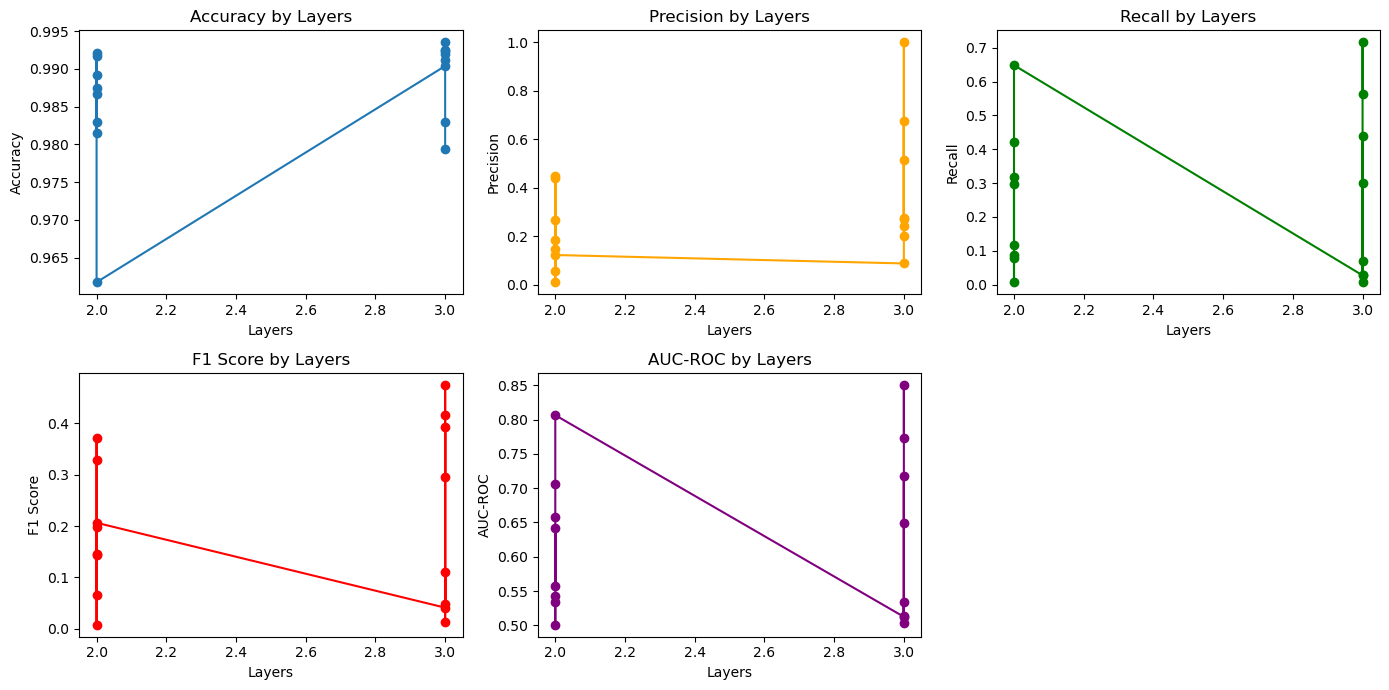

In [92]:
# Setting up the figure
plt.figure(figsize=(14, 7))

# Plotting accuracy
plt.subplot(2, 3, 1)
plt.plot(layers_list, accuracy_list, marker='o', label='Accuracy')
plt.xlabel('Layers')
plt.ylabel('Accuracy')
plt.title('Accuracy by Layers')

# Plotting precision
plt.subplot(2, 3, 2)
plt.plot(layers_list, precision_list, marker='o', color='orange', label='Precision')
plt.xlabel('Layers')
plt.ylabel('Precision')
plt.title('Precision by Layers')

# Plotting recall
plt.subplot(2, 3, 3)
plt.plot(layers_list, recall_list, marker='o', color='green', label='Recall')
plt.xlabel('Layers')
plt.ylabel('Recall')
plt.title('Recall by Layers')

# Plotting F1
plt.subplot(2, 3, 4)
plt.plot(layers_list, f1_list, marker='o', color='red', label='F1 Score')
plt.xlabel('Layers')
plt.ylabel('F1 Score')
plt.title('F1 Score by Layers')

# Plotting AUC-ROC
plt.subplot(2, 3, 5)
plt.plot(layers_list, auc_roc_list, marker='o', color='purple', label='AUC-ROC')
plt.xlabel('Layers')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC by Layers')

plt.tight_layout()
plt.show()


In [96]:
X_val_np = X_best.numpy() if isinstance(X_best, torch.Tensor) else X_best
y_val_np = y_best.numpy() if isinstance(y_best, torch.Tensor) else y_best

print(X_val_np.shape)
print(y_val_np.shape)

(319, 121, 43)
(319, 121)


In [97]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

def permutation_importance_sequential(model, X, y, metric=accuracy_score, device='cpu'):
    model.eval()
    
    # Flatten the predictions if your model outputs one prediction per sequence
    with torch.no_grad():
        original_preds = model(torch.tensor(X, dtype=torch.float).to(device)).sigmoid().cpu().numpy()
    original_preds = (original_preds > 0.5).astype(int).flatten()

    y_flat = y.flatten().astype(int)
    original_score = metric(y_flat, original_preds)

    importance_scores = {}
    for feature in range(X.shape[2]):  # Iterate over each feature
        X_shuffled = X.copy()
        for i in range(X.shape[0]):  # Shuffle feature across all time steps for each sample
            np.random.shuffle(X_shuffled[i, :, feature])

        with torch.no_grad():
            shuffled_preds = model(torch.tensor(X_shuffled, dtype=torch.float).to(device)).sigmoid().cpu().numpy()
        shuffled_preds = (shuffled_preds > 0.5).astype(int).flatten()

        shuffled_score = metric(y_flat, shuffled_preds)
        importance_scores[feature] = original_score - shuffled_score

    return importance_scores


# Assuming X_val and y_val are your validation features and labels in NumPy array format
X_val_np = X_val.numpy() if isinstance(X_val, torch.Tensor) else X_val
y_val_np = y_val.numpy() if isinstance(y_val, torch.Tensor) else y_val

importance_scores = permutation_importance_sequential(model, X_val_np, y_val_np, device=device)

In [112]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import cohen_kappa_score, log_loss

def permutation_importance_sequential_average(model, X, y, metric=roc_auc_score, device='cpu', n_repeats=30):
    model.eval()
    feature_importances = np.zeros((X.shape[2], n_repeats))

    nrOfLoops=0
    for n in range(n_repeats):
        nrOfLoops =nrOfLoops + 1
        print("loop:",nrOfLoops)
        # Flatten the predictions if your model outputs one prediction per sequence
        with torch.no_grad():
            original_preds = model(torch.tensor(X, dtype=torch.float).to(device)).sigmoid().cpu().numpy()
        original_preds = (original_preds > 0.5).astype(int).flatten()

        y_flat = y.flatten().astype(int)
        original_score = metric(y_flat, original_preds)

        for feature in range(X.shape[2]):  # Iterate over each feature
            X_shuffled = X.copy()
            for i in range(X.shape[0]):  # Shuffle feature across all time steps for each sample
                np.random.shuffle(X_shuffled[i, :, feature])

            with torch.no_grad():
                shuffled_preds = model(torch.tensor(X_shuffled, dtype=torch.float).to(device)).sigmoid().cpu().numpy()
            shuffled_preds = (shuffled_preds > 0.5).astype(int).flatten()

            shuffled_score = metric(y_flat, shuffled_preds)
            feature_importances[feature, n] = original_score - shuffled_score

    # Average the feature importances across all repeats
    average_importances = feature_importances.mean(axis=1)

    # Optionally, return a dictionary mapping feature index to its average importance
    importance_scores = {feature: average_importances[feature] for feature in range(X.shape[2])}

    return importance_scores

# Assuming X_val and y_val are your validation features and labels in NumPy array format
X_val_np = X_val.numpy() if isinstance(X_val, torch.Tensor) else X_val
y_val_np = y_val.numpy() if isinstance(y_val, torch.Tensor) else y_val

# Call the function with your model, validation dataset, device, and the number of repeats
importance_scores = permutation_importance_sequential_average(model, X_val_np, y_val_np, device=device, n_repeats=5)


loop: 1
loop: 2
loop: 3
loop: 4
loop: 5


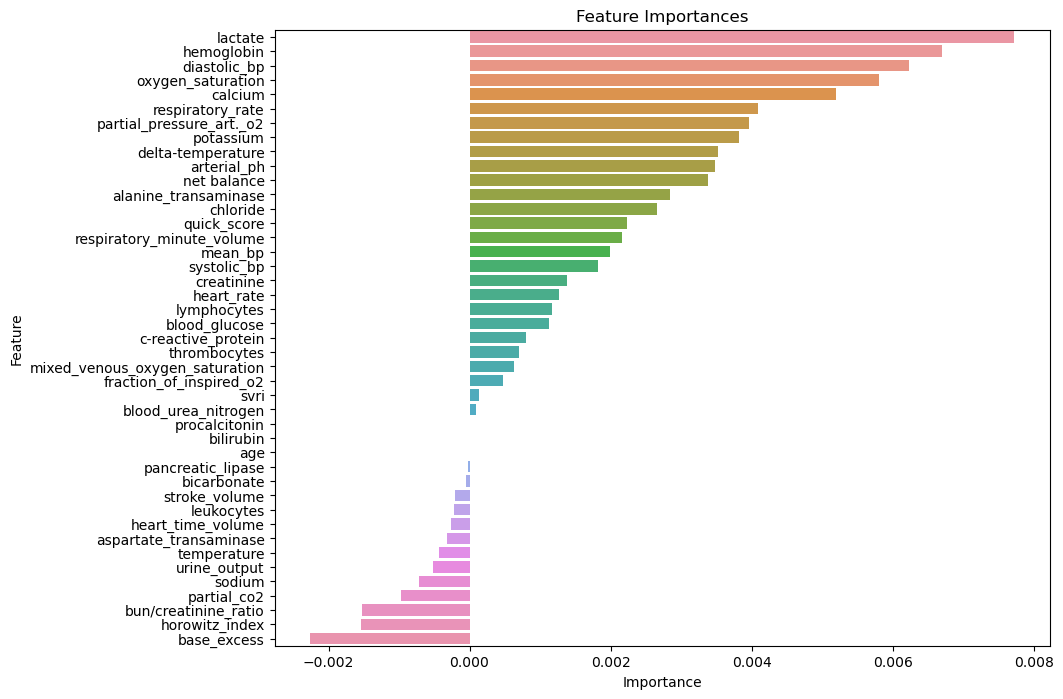

In [113]:
newDict = {}
features_map = [feature for feature in features if feature != "id"]
for index, importance in importance_scores.items():
    feature_name = features_map[index] 
    newDict[feature_name] = importance

importances_df = pd.DataFrame(list(newDict.items()), columns=['Feature', 'Importance'])

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=importances_df.sort_values('Importance', ascending=False), x='Importance', y='Feature')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [64]:
def predict_fn(x):
    # Convert the input to tensor if it's not and ensure it has the right shape
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    
    # Ensure x is 3D: [batch_size, sequence_length, features]
    if x.dim() == 2:
        x = x.unsqueeze(1)  # Adds a sequence length of 1
    
    # Move the tensor to the correct device
    x = x.to(device)
    
    # Ensure model is in evaluation mode
    model.eval()
    
    with torch.no_grad():
        predictions = model(x)
        # Convert predictions to probabilities if it's a classification model
        predictions = torch.softmax(predictions, dim=1).cpu().numpy()
    
    #return predictions.cpu().numpy()
    return predictions


In [65]:
import shap

# Sample a subset of your validation dataset and ensure it's 2D
# Here, `shap.sample()` is replaced with manual sampling and reshaping for clarity
num_samples = 100  # Number of samples to use for background distribution
selected_time_step = 0  # Example: choose the first time step for simplicity

# Ensure X_val_np is a numpy array and select a specific time step for all samples
X_val_sampled = X_val_np[:num_samples, selected_time_step, :]  # This selects the first time step for the first `num_samples`

# Now, ensure that explainer is created with 2D data
explainer = shap.KernelExplainer(predict_fn, X_val_sampled)

# Similarly, when computing SHAP values, ensure the input data is 2D
X_val_to_explain = X_val_np[:10, selected_time_step, :]  # Explain the first 10 samples at the selected time step
shap_values = explainer.shap_values(X_val_to_explain)


#visualize
#shap.force_plot(explainer.expected_value, shap_values[0], X_val_to_explain)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


In [67]:
shap.initjs()
# Visualization
shap.force_plot(
    base_value=explainer.expected_value[0],  # Base value or expected value of the model
    shap_values=shap_values[0],  # SHAP values for a single instance or batch
    features=X_val_to_explain  # Features corresponding to shap_values
)

In [ ]:
shap.interaction_plot(feature_index, shap_values, features)

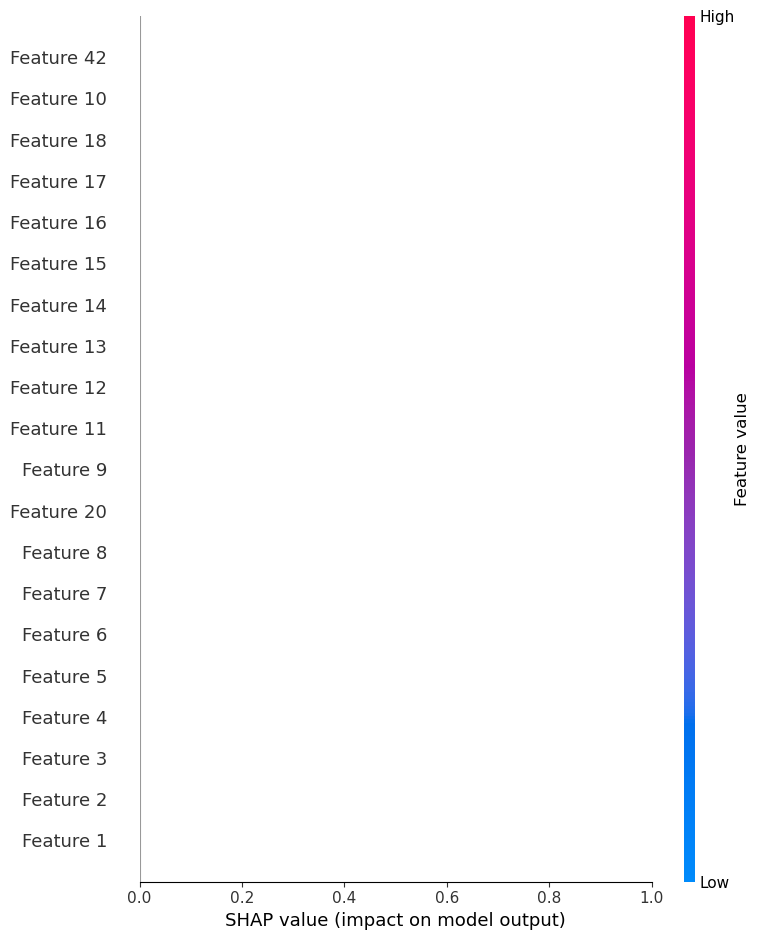

In [68]:
# If shap_values is a list of lists with a single inner list (for a single-output model),
# extract the inner list:
if isinstance(shap_values, list) and len(shap_values) == 1:
    shap_values = shap_values[0]

# Now try creating the beeswarm plot again
shap.summary_plot(shap_values, X_val_np[0], plot_type="beeswarm")


In [ ]:
# Flatten the last two dimensions of X_val_np if your SHAP values are for the flattened array
# This changes X_val_np from shape (num_samples, sequence_length, num_features)
# to shape (num_samples, sequence_length * num_features)
X_val_np_flattened = X_val_np.reshape(X_val_np.shape[0], -1)

# Now you can plot the SHAP summary
shap.summary_plot(shap_values, X_val_np_flattened, plot_type="beeswarm")


# Compute SHAP values (make sure this step was successful)
shap_values = explainer.shap_values(X_val_to_explain)

# Since we are using only the first time step, we don't need to flatten the array
# Just use the sampled data at the specific time step for all samples
X_val_to_explain_all = X_val_np[:, selected_time_step, :]

# Now you can plot the SHAP summary
shap.summary_plot(shap_values, X_val_to_explain_all, plot_type="beeswarm")


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [ ]:
# Convert the input data to a PyTorch tensor and send it to the correct device
X_val_to_explain_tensor = torch.tensor(X_val_to_explain, dtype=torch.float32).to(device)

# Compute SHAP values
shap_values = explainer.shap_values(X_val_to_explain_tensor)

# Assuming the computation of SHAP values is now successful, proceed to create the plot

# Use the sampled data at the specific time step for all samples
X_val_to_explain_all = X_val_np[:, selected_time_step, :]

# Now you can plot the SHAP summary
# Convert the SHAP values to a numpy array if they are not already
shap_values_np = [sv.cpu().numpy() if isinstance(sv, torch.Tensor) else sv for sv in shap_values]
shap.summary_plot(shap_values_np, X_val_to_explain_all, plot_type="beeswarm")


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [ ]:
# Ensure the SHAP explainer is created with a background dataset that matches the model's input requirements
explainer = shap.KernelExplainer(predict_fn, X_val_sampled)

# Ensure X_val_to_explain is a numpy array and has the expected number of dimensions
# We expect it to be of shape (num_samples, sequence_length, num_features)
if len(X_val_to_explain.shape) == 2:
    # If X_val_to_explain is 2D, add a sequence_length dimension of 1
    X_val_to_explain = X_val_to_explain.reshape((X_val_to_explain.shape[0], 1, X_val_to_explain.shape[1]))

# Convert X_val_to_explain to a tensor and move it to the correct device
X_val_to_explain_tensor = torch.tensor(X_val_to_explain, dtype=torch.float32).to(device)

# Now compute the SHAP values
shap_values = explainer.shap_values(X_val_to_explain_tensor)


AssertionError: Unknown instance type: <class 'torch.Tensor'>

## Result and discussion